# Foundations of AI/ML by IIIT-Hyderabad & Talent Sprint
# Lab04 Experiment 02 - Part 2

# Image Classification

In this experiment, we shall see:

- **1. FEATURE EXTRACTION**
    - extract eigenvalues and eigenvectors, and choose the best N principal components as features
    - use deep features


- **2. MODEL SELECTION**: try 6 different models, and choose the model with the highest validation accuracy:

    - 1) use Naive Bayes classifier with PCA features, and find validation accuracy
    - 2) use Naive Bayes classifier with Deep features, and find validation accuracy
    - 3) use kNN classifier with PCA features, and find validation accuracy
    - 4) use kNN classifier with Deep features, and find validation accuracy
    - 5) use linear classifier with PCA features, and find validation accuracy
    - 6) use linear classifier with Deep features, and find validation accuracy


- **3. PREDICTION**: use the 6 models to predict labels on test data, and see how well the validation accuracy estimated the test accuracy.


- **4. COMPARISON OF ALL ACCURACIES**: compare training, validation and testing accuracies.

Let us go through these step-by-step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classifiers import *

# Recap of Part 1

In Part 1, we understood the data, and split it into train, val, and test. We then manipulated it so that the data is of uniform size, normalized, and mean subtracted. (Not that these operations can be performed on any data, not just images.)

We then saved the final datasets as "data.npz" file. Let us load them:

In [3]:
# Loading data
data = np.load("data.npz")

# Getting train, val and test data and labels, and the mean_image
data_train = data["data_train"]
labels_train = data["labels_train"]
data_val = data["data_val"]
labels_val = data["labels_val"]
data_test = data["data_test"]
labels_test = data["labels_test"]
mean_image = data["mean_image"]

**Exercise 6: Plot the first 50 training images. You can use _matplotlib_ or any library of your choice.**

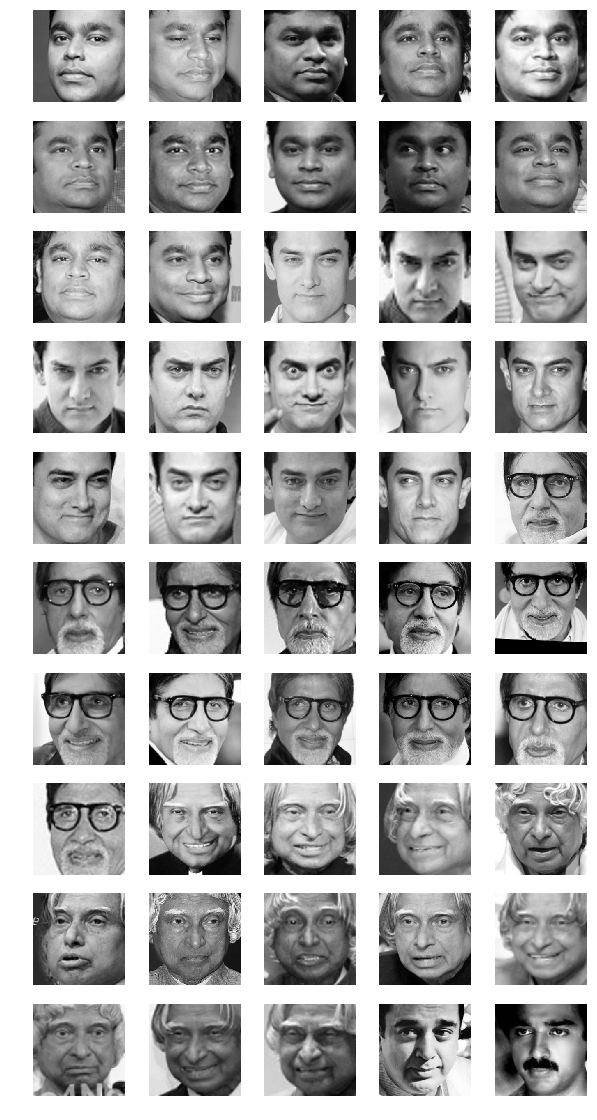

In [4]:
# Plot the first 50 images

# Number of images to be plotted
N = 50

plt.figure(figsize=(10, 2*(N+5)//5))

for i in range(N):
    
    # Make a subplot
    plt.subplot((N+5)//5, 5, i+1)
    
    # Plot the image, after reshaping it to (224, 224)
    plt.imshow(np.reshape(data_train[i] + mean_image, (224, 224)), cmap='gray')
    
    # Turn off axis lines
    plt.axis("off")

plt.show()


# 1. FEATURE EXTRACTION

For the given problem, we would be using **two** types of features - PCA, and Deep Features.

After this exercise, we will compare the results using the two different types of features on the validation set. We shall then fix the final model based on which feature set performs better according to an evaluation metric.

# 1.1. First $N$ Principal Components with maximum eigenvalues

As we have learnt in the lecture, PCA finds the set of orthonormal vectors which best
describe the distribution of the underlying dataset. In the given dataset, we have $n$
images of size $K \times K$. (We know that $K = 224$, and $n = 120$ in the training set)

We have already seen how PCA features are extracted, let us recap them:

## 1.1.1. Find eigenvalues and eigenvectors

In [5]:
eigenvalues, eigenvectors = find_eigenvalues_and_eigenvectors_simply(data_train)

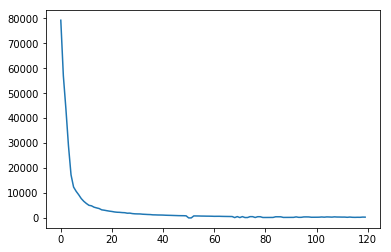

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(eigenvalues)

## 1.1.2. Reordering, normalizing

But, since we found the eigenvalues and eigenvectors in a roundabout way, we need to:
- reorder them so that they are in descending order of eigenvalues,
- normalize the eigenvectors so that their norms are 1.

In [9]:
# REORDER

# Find the required order of indices to make decreasing order of eigenvalue
sort_index = np.argsort(eigenvalues)[::-1]

# Use the calculated order of indices to reorder eigenvalues and eigenvectors
eigenvalues = eigenvalues[sort_index]
eigenvectors = eigenvectors[:, sort_index]

In [10]:
# NORMALIZE
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

In [32]:
eigenvalues.shape

(120,)

## 1.1.3. Eigenfaces

The eigenvectors thus found are called eigenfaces (because we found the eigenvectors of faces...).

Since an eigenvector is of dimension ($K^2$,), it can be reshaped to $(K, K)$ and displayed as an image!

**Exercise 7: Display the first 50 eigenfaces.** Hint: we solved a similar problem in Exercise 6.

In [33]:
newegvector = np.reshape(eigenvectors[:, 0], (224, 224))
newegvector.shape

(224, 224)

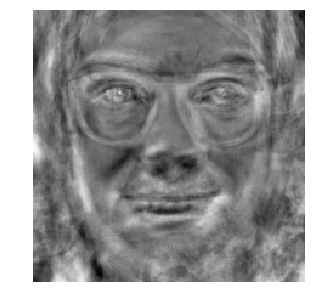

In [30]:
plt.figure(figsize=(10, 5))
plt.imshow(np.reshape(eigenvectors[:, 0], (224, 224)), cmap='gray')
plt.axis("off")
plt.show()

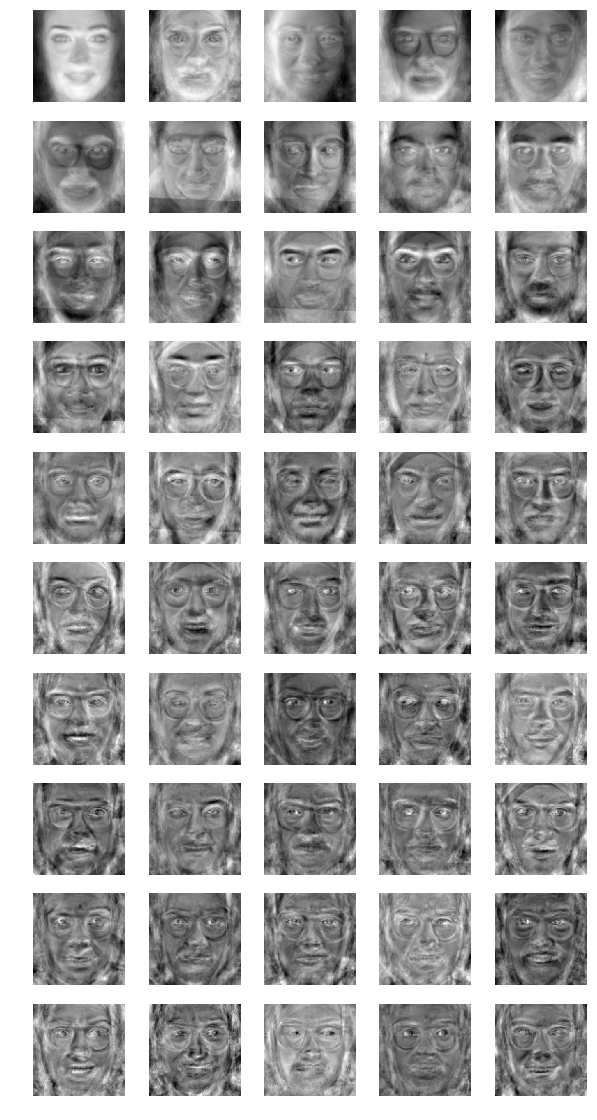

In [11]:
# Plot the first 50 eigenfaces
# Your code here
N = 50

plt.figure(figsize=(10, 2*(N+5)//5))

for i in range(N):
    
    # Make a subplot
    plt.subplot((N+5)//5, 5, i+1)
    
    # Plot the eigenface, after reshaping it to (224, 224)
    # Remember eigenfaces are **columns** in the matrix
    plt.imshow(np.reshape(eigenvectors[:, i], (224, 224)), cmap='gray')
    
    # Turn off axis lines
    plt.axis("off")

plt.show()

## 1.1.4. Computing good value for $N$

_(already seen in previous lab)_

In the given dataset, there are as many eigenvectors as the number of training examples. This can be verified by:

In [12]:
eigenvectors.shape

(50176, 120)

Since each column is an eigenvector, there are 120 eigenvectors, each of 50176 dimensions. But usually, a smaller number $N$ of eigenvectors is chosen as a basis to make feature vectors.

To decide the on the number $N$, i.e. the number of most important eigenvectors to keep as the basis, the cumulative sum of eigenvalues (assuming they are in decreasing order) divided by the total sum of eigenvalues, vs. the number of eigenvalues considered ($M$) is plotted.

This plot shall show the fraction of total variance retained ($r$) vs. the number of eigenvalues considered ($M$). This way, the plot gives a good understanding of the point of diminishing returns, i.e. the point where little variance is retained by retaining additional eigenvalues.

This can be understood by the following equation:

$$r = \frac{\sum_{k=1}^{M}\lambda_k}{\sum_{k=1}^{n}\lambda_k},\ \ \ \  M <= n$$

Plotting $r$ vs $M$ shall give a good idea of the impact of varying $M$ on $r$.

Let's say we want to retain only 80% of the variance involved. Then we should look for the minimum value of $M$ for which $r > 0.8$.

**Plot $r$ vs $M$:**

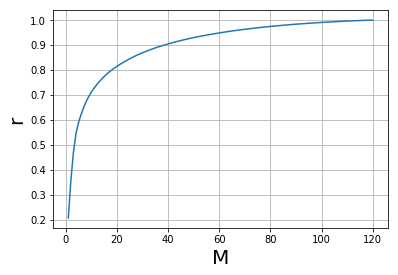

In [13]:
# Plot r vs M

# Values of M to consider: 1, 2,..., n
M = np.array(range(1, len(data_train) + 1))

# Calculate r for all values of M
r = np.cumsum(eigenvalues)/np.sum(eigenvalues)

# Plot r vs M
plt.plot(M, r)
plt.xlabel("M", fontsize=20)
plt.ylabel("r", fontsize=20)
plt.grid("on")
plt.show()

We can see from the plot that an $M$ value of around 20 gives an $r$ value of 0.8.

So let us choose $N = 20$.

In [14]:
N = 20

This means we are choosing only $N$ **principal components**. In other words, we are choosing those $N$ types of information that are most important in faces. We can look at the plots of the eigenfaces to see what sort of information we are choosing.

Let us note the first N principal components, i.e. the first N eigenvectors:

In [15]:
pca_vectors = eigenvectors[:, :N]

## 1.1.5. Finding features using first $N$ Principal Components

_(already seen in previous lab)_

Since we are using the most important eigenfaces as the _basis_ vectors, we need to project the data into these basis components to find the relevant features. We do this by finding the dot product of the data maxtrix and the matrix of the most important eigenvectors.

We know that the data (`data_train`, `data_val`, `data_test`) is of shape $n \times K^2$. We also know that the `pca_vectors` matrix is of shape $K^2 \times N$.

In [16]:
pca_features_train = np.dot(data_train, pca_vectors)
pca_features_val = np.dot(data_val, pca_vectors)
pca_features_test = np.dot(data_test, pca_vectors)

Let's check the shapes of the features:

In [17]:
print(pca_features_train.shape, pca_features_val.shape, pca_features_test.shape)

(120, 20) (40, 20) (40, 20)


Hence, we can see that we have transformed our data from $n \times K^2$ to $n \times N$.

# 1.2. Deep features

We used a deep neural network to transform the images into 2622 good features. Let us read these features: 

In [18]:
# Deep features
deep_features = np.load("../../Datasets/vgg_face_indian_dataset/vgg_face_deep_features.npz")
deep_features_train = deep_features["train"]
deep_features_val = deep_features["val"]
deep_features_test = deep_features["test"]

In [19]:
print(deep_features_train.shape, deep_features_val.shape, deep_features_test.shape)

(120, 2622) (40, 2622) (40, 2622)


# 2. Training and Prediction

Till now, we have gotten familiar with kNN algorithm and linear classifier. We have PCA features and Deep features at our disposal.

Let us now train the following 6 models on the training set, and compare accuracies on the test set to see which model performs better using which feature:

- 1) Naive bayes classifer on PCA features,
- 2) Naive bayes classifer on deep features,
- 3) kNN classifier on PCA features,
- 4) kNN classifier on Deep features,
- 5) linear classifier on PCA features,
- 6) linear classifier on Deep features,

## Function to choose algorithm, features and labels to get accuracy

We created a convenient function to which you can choose the algorithm you want to use - `'kNN'`, `'NB'` (Naive Bayes), or `'linear'` (multiclass linear classifier) - and input features and labels for training and testing:

**`acc = predict_and_find_accuracy(algorithm, train_features, train_labels, given_features, given_labels, k)`**

INPUTS:

- **`algorithm`** is one of `'kNN'`, `'NB'` (Naive Bayes), and `'linear'`,


- **`train_features`** are either `pca_features_train` or `deep_features_train`,


- **`train_labels`** are `labels_train`,


- **`given_features`** are `XXX_features_val` in case of validation, and `XXX_features_test` in case of testing (`XXX` being either `pca` or `deep` depending on what you chose to train the model on)


- **`given_labels`** are `labels_val` in case of validation, and `labels_test` in case of testing.


- **`k`** is the value of $k$ to be used _in case_ we are using kNN classifier.

OUTPUT:

- **acc** is the accuracy of the `algorithm` on `given_features` & `given_labels` after being trained on `train_features` & `train_labels`.

# 2.1 Naive Bayes algorithm

## 2.1.1 Test accuracy with PCA features

**Exercise 8: Find the test accuracy of a Naive Bayes classifier on PCA features using the convenient function.**

In [20]:
NB_pca_test_acc = predict_and_find_accuracy("NB",  pca_features_train, labels_train, pca_features_test, labels_test)
print(NB_pca_test_acc)

0.725


## 2.1.1 Test accuracy with Deep features

**Exercise 9: Find the test accuracy of a Naive Bayes classifier on deep features using the convenient function.**

In [21]:
NB_deep_test_acc = predict_and_find_accuracy("NB",  deep_features_train, labels_train, deep_features_test, labels_test)
print(NB_deep_test_acc)

0.15


# 2.2. k Nearest Neighbours

By now, we are quite familiar with the kNN algorithm.

But how to find the best value of $k$? We will use the validation set to determine this.

## 2.2.1 Find best $k$ for PCA features and Test accuracy

**Exercise 10:** Using the convenient function, find the validation accuracies of a kNN classifier on pca_features using different values of $k$. Then, choose that $k$ which gives the best validation accuracy. Finally, use this $k$ to get the test accuracy.

We shall choose a $k$ among {1, 3, 5, 7, 9, 11}.

In [23]:
values_of_k = [1, 3, 5, 7, 9, 11]

In [24]:
# Your code here
pca_k_acc = []

for k in values_of_k:
    pca_k_acc.append(predict_and_find_accuracy("kNN", pca_features_train, labels_train, pca_features_val, labels_val, k))
    
best_pca_k = values_of_k[np.argmax(pca_k_acc)]
print(best_pca_k)

kNN_pca_test_acc = predict_and_find_accuracy("kNN",  pca_features_train, labels_train, pca_features_test, labels_test, best_pca_k)
print(kNN_pca_test_acc)

1
0.525


The best $k$ for PCA should be 1.

---- **(If not, please recheck your code)**

## 2.2.2 Find best $k$ for Deep features and Test accuracy

**Exercise 11:** Using the convenient function, find the validation accuracies of a kNN classifier on deep_features using different values of $k$. Then, choose that $k$ which gives the best validation accuracy. Finally, use this $k$ to get the test accuracy.

We shall choose a $k$ among {1, 3, 5, 7, 9, 11}.

In [25]:
# Your code here

values_of_k = [1, 3, 5, 7, 9, 11]

deep_k_acc = []

for k in values_of_k:
    deep_k_acc.append(predict_and_find_accuracy("kNN", deep_features_train, labels_train, deep_features_val, labels_val, k))
    
best_deep_k = values_of_k[np.argmax(deep_k_acc)]
print(best_deep_k)

kNN_deep_test_acc = predict_and_find_accuracy("kNN",  deep_features_train, labels_train, deep_features_test, labels_test, best_deep_k)
print(kNN_deep_test_acc)

1
0.375


The best $k$ for deep features should be 1.

---- **(If not, please recheck your code)**

# 2.3 Multi-class Linear Classifier

## 2.3.1 Test accuracy with PCA features

**Exercise 12: Find the test accuracy of a linear classifier on PCA features using the convenient function.**

In [26]:
linear_pca_test_acc = predict_and_find_accuracy("linear",  pca_features_train, labels_train, pca_features_test, labels_test)
print(linear_pca_test_acc)

0.65


## 2.3.2 Test accuracy with Deep features

**Exercise 13: Find the test accuracy of a linear classifier on Deep features using the convenient function.**

In [27]:
linear_deep_test_acc = predict_and_find_accuracy("linear",  deep_features_train, labels_train, deep_features_test, labels_test)
print(linear_deep_test_acc)

0.325


**Exercise 14: (Discuss) If this were a _retrieval_ problem, what other metrics would you evaluate to compare different models?**

# 3. COMPARISON OF ACCURACIES OVER THE 6 MODELS

We have trained and tested 6 different models:
- 1) Naive Bayes classifier on PCA features,
- 2) Naive Bayes classifier on Deep features,
- 3) kNN classifier on PCA features,
- 4) kNN classifier on Deep features,
- 5) linear classifier on PCA features,
- 6) linear classifier on Deep features,

As an additional note, we shall find the training and validation accuracies for each model, and see all the accuracies side-by-side: training accuracy, validation accuracy and test accuracy:

In [28]:
# Finding training accuracies
NB_pca_train_acc = predict_and_find_accuracy("NB", pca_features_train, labels_train, pca_features_train, labels_train)
NB_deep_train_acc = predict_and_find_accuracy("NB", deep_features_train, labels_train, deep_features_train, labels_train)
kNN_pca_train_acc = predict_and_find_accuracy("kNN", pca_features_train, labels_train, pca_features_train, labels_train, best_pca_k)
kNN_deep_train_acc = predict_and_find_accuracy("kNN", deep_features_train, labels_train, deep_features_train, labels_train, best_deep_k)
linear_pca_train_acc = predict_and_find_accuracy("linear", pca_features_train, labels_train, pca_features_train, labels_train)
linear_deep_train_acc = predict_and_find_accuracy("linear", deep_features_train, labels_train, deep_features_train, labels_train)

# Finding validation accuracies
NB_pca_val_acc = predict_and_find_accuracy("NB", pca_features_train, labels_train, pca_features_val, labels_val)
NB_deep_val_acc = predict_and_find_accuracy("NB", deep_features_train, labels_train, deep_features_val, labels_val)
kNN_pca_val_acc = predict_and_find_accuracy("kNN", pca_features_train, labels_train, pca_features_val, labels_val, best_pca_k)
kNN_deep_val_acc = predict_and_find_accuracy("kNN", deep_features_train, labels_train, deep_features_val, labels_val, best_deep_k)
linear_pca_val_acc = predict_and_find_accuracy("linear", pca_features_train, labels_train, pca_features_val, labels_val)
linear_deep_val_acc = predict_and_find_accuracy("linear", deep_features_train, labels_train, deep_features_val, labels_val)

In [29]:
print("      Model                      Train acc      Val acc     Test acc ")
print("---------------------------------------------------------------------")
print("Naive Bayes with PCA features  :   ", "{0:.03f}".format(NB_pca_train_acc),  "      ", "{0:.03f}".format(NB_pca_val_acc), "      ", "{0:.03f}".format(NB_pca_test_acc))
print("Naive Bayes with Deep features :   ", "{0:.03f}".format(NB_deep_train_acc),  "      ", "{0:.03f}".format(NB_deep_val_acc), "      ", "{0:.03f}".format(NB_deep_test_acc))
print("kNN with PCA features          :   ", "{0:.03f}".format(kNN_pca_train_acc),  "      ", "{0:.03f}".format(kNN_pca_val_acc), "      ", "{0:.03f}".format(kNN_pca_test_acc))
print("kNN with Deep features         :   ", "{0:.03f}".format(kNN_deep_train_acc),  "      ", "{0:.03f}".format(kNN_deep_val_acc), "      ", "{0:.03f}".format(kNN_deep_test_acc))
print("Linear with PCA features       :   ", "{0:.03f}".format(linear_pca_train_acc),  "      ", "{0:.03f}".format(linear_pca_val_acc), "      ", "{0:.03f}".format(linear_pca_test_acc))
print("Linear with Deep features      :   ", "{0:.03f}".format(linear_deep_train_acc),  "      ", "{0:.03f}".format(linear_deep_val_acc), "      ", "{0:.03f}".format(linear_deep_test_acc))

      Model                      Train acc      Val acc     Test acc 
---------------------------------------------------------------------
Naive Bayes with PCA features  :    0.958        0.600        0.725
Naive Bayes with Deep features :    0.142        0.175        0.150
kNN with PCA features          :    1.000        0.575        0.525
kNN with Deep features         :    1.000        0.475        0.375
Linear with PCA features       :    0.958        0.625        0.650
Linear with Deep features      :    0.433        0.350        0.325


We can observe that in most cases, training accuracies are quite high, while validation and testing accuracies are not. Thus, a much better estimate of the test accuracy is the validation accuracy, rather than the training accuracy.

### Low accuracies:

As can be seen, the values of the validation accuracies do not go above 0.625, with PCA giving better accuracy than deep features. This is much better than the accuracy of a random guess (0.1), but it is quite less on an absolute level.

**Reason:** We used **ONLY** 12 training images per class. That is not nearly enough to train any machine learning model!

Machine learning models, especially deep models, always perform better with more data. This is why we have seen "Big Data" become popular - we now have access to large amounts of data, which is making all the machine learning models better than ever before.

So, in real cases where we don't have a test set, we make a small validation data and find validation accuracy to choose our model. From the validation accuracies, we find that the **Linear Classifier** and **Naive Bayes Classifier** using **principal eigenfaces** perform better than the other models which hold for test accuracies too.

# CONCLUSION

Through the above exercises, we learnt about the fundamental parts of a Machine Learning system. Apart from learning the importance of validation set, we revised a few concepts we have gone through in past few lectures such as PCA, Naive bayes, kNN, multi-class linear classifiers, and evaluation metrics.

# SOLUTIONS

## Exercise 6

In [ ]:
# Number of images to be plotted
N = 50

plt.figure(figsize=(10, 2*(N+5)//5))

for i in range(N):
    
    # Make a subplot
    plt.subplot((N+5)//5, 5, i+1)
    
    # Plot the image, after reshaping it to (224, 224)
    plt.imshow(np.reshape(data_train[i] + mean_image, (224, 224)), cmap='gray')
    
    # Turn off axis lines
    plt.axis("off")

plt.show()

## Exercise 7

In [ ]:
# Number of eigenfaces to be plotted
N = 50

plt.figure(figsize=(10, 2*(N+5)//5))

for i in range(N):
    
    # Make a subplot
    plt.subplot((N + 5)//5, 5, i+1)
    
    # Plot the eigenface, after reshaping it to (224, 224)
    # Remember eigenfaces are **columns** in the matrix
    plt.imshow(np.reshape(eigenvectors[:, i], (224, 224)), cmap='gray')
    
    # Turn off axis lines
    plt.axis("off")

plt.show()

## Exercise 8

In [ ]:
NB_pca_test_acc = predict_and_find_accuracy("NB",  pca_features_train, labels_train, pca_features_test, labels_test)
print(NB_pca_test_acc)

## Exercise 9

In [ ]:
NB_deep_test_acc = predict_and_find_accuracy("NB",  deep_features_train, labels_train, deep_features_test, labels_test)
print(NB_deep_test_acc)

## Exercise 10

In [ ]:
pca_k_acc = []

for k in values_of_k:
    pca_k_acc.append(predict_and_find_accuracy("kNN", pca_features_train, labels_train, pca_features_val, labels_val, k))
    
best_pca_k = values_of_k[np.argmax(pca_k_acc)]
print(best_pca_k)

kNN_pca_test_acc = predict_and_find_accuracy("kNN",  pca_features_train, labels_train, pca_features_test, labels_test, best_pca_k)
print(kNN_pca_test_acc)

## Exercise 11

In [ ]:
deep_k_acc = []

for k in values_of_k:
    deep_k_acc.append(predict_and_find_accuracy("kNN", deep_features_train, labels_train, deep_features_val, labels_val, k))
    
best_deep_k = values_of_k[np.argmax(deep_k_acc)]
print(best_deep_k)

kNN_deep_test_acc = predict_and_find_accuracy("kNN",  deep_features_train, labels_train, deep_features_test, labels_test, best_deep_k)
print(kNN_deep_test_acc)

## Exercise 12

In [ ]:
linear_pca_test_acc = predict_and_find_accuracy("linear",  pca_features_train, labels_train, pca_features_test, labels_test)
print(linear_pca_test_acc)

## Exercise 13

In [ ]:
linear_deep_test_acc = predict_and_find_accuracy("linear",  deep_features_train, labels_train, deep_features_test, labels_test)
print(linear_deep_test_acc)

## Exercise 14

precision@K and recall@K are more relevant metrics for retrieval problems.

In [ ]:
#       Model                      Train acc      Val acc     Test acc 
# ---------------------------------------------------------------------
# Naive Bayes with PCA features  :    0.958        0.600        0.725
# Naive Bayes with Deep features :    0.142        0.175        0.150
# kNN with PCA features          :    1.000        0.575        0.525
# kNN with Deep features         :    1.000        0.475        0.375
# Linear with PCA features       :    0.958        0.625        0.650
# Linear with Deep features      :    0.433        0.350        0.325